In [1]:
from collections import defaultdict
import copy
import random
import os
import shutil
import glob
from urllib.request import urlretrieve

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

In [2]:
cat_directory = "D:/Dataset/dataset/etc/dogs_cats/cat/"
dog_directory = "D:/Dataset/dataset/etc/dogs_cats/dog/"

cat_images_filepaths = sorted(glob.glob(cat_directory+"*"))
dog_images_filepaths = sorted(glob.glob(dog_directory+"*"))
print(len(cat_images_filepaths), len(dog_images_filepaths))
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
random.seed(42)
random.shuffle(images_filepaths)
train_images_filepaths = images_filepaths[:20000]
val_images_filepaths = images_filepaths[20000:-10]
test_images_filepaths = images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

12500 12500
20000 4990 10


In [4]:
class CatsVsDogsDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "Cat":
            label = 1.0
        else:
            label = 0.0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [5]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = CatsVsDogsDataset(images_filepaths=train_images_filepaths, transform=train_transform)

In [6]:
val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = CatsVsDogsDataset(images_filepaths=val_images_filepaths, transform=val_transform)

In [8]:
for image, label in train_dataset:
    break
    
image.shape

torch.Size([3, 128, 128])

In [7]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

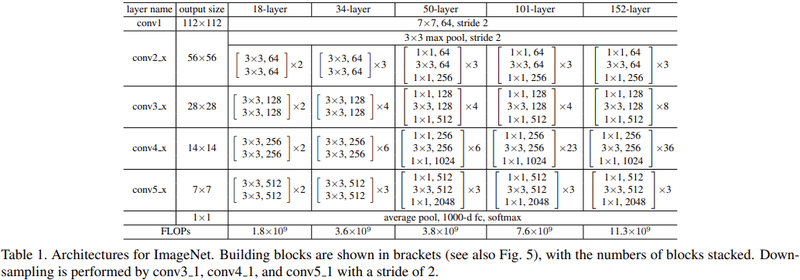

In [28]:
test_imgbatch = torch.rand((4,3,128,128))
test_imgbatch.size()

torch.Size([4, 3, 128, 128])

In [46]:
class Res_id_block(nn.Module):
    def __init__(self, in_c, out_c, plain=False):
        super().__init__()
        self.plain = plain
        self.conv1 = nn.Conv2d(in_c,out_c,kernel_size=3,stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_c,out_c,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        
    def forward(self, x):
        skip = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if not self.plain:
            x = x + skip
        x = self.relu(x) # element-wise add
        return x

In [47]:
class Res_conv_block(nn.Module):
    def __init__(self, in_c, out_c, plain=False):
        super().__init__()
        self.plain = plain
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3,stride=2,padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c,out_c, kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.skipconv = nn.Conv2d(in_c,out_c,kernel_size=1,stride=2,padding=0)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        skip = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        skip = self.skipconv(skip)
        if not self.plain:
            x = x + skip
        x = self.relu(x)
        return x

In [53]:
class Resnet34(nn.Module):
    def __init__(self, n_block=[3,4,6,3]):
        super().__init__()
        # input image 128, 3
        self.conv1 = nn.Conv2d(3, 64, 7, 2) #output 61, 64
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        for i, n in enumerate(n_block):
            if i == 0:
                self.conv = torch.nn.Sequential()
                for 
                
        
        self.block1 = Res_id_block(64,64)
        self.conblock1 = Res_conv_block(64,128)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.block1(x)
        x = self.conblock1(x)
    
net = Resnet34()
net(test_imgbatch)

torch.Size([4, 3, 128, 128])
torch.Size([4, 64, 61, 61])
torch.Size([4, 64, 30, 30])
torch.Size([4, 64, 30, 30])
torch.Size([4, 128, 15, 15])
